In [1]:
# Group 6 — Telco Churn (Imbalanced)
#Full pipeline: Clean -> EDA -> Encode -> Split -> Models (RF/SVM/KNN) -> SMOTE -> CV -> Test eval

# =========================
# 1) IMPORTS
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 200)

# =========================
# 2) LOAD + CLEAN
# =========================
url = "https://raw.githubusercontent.com/takapia95/Group6_Telco_RF_Imbalance/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn(in).csv"
df = pd.read_csv('TelcoCustomerChurn.csv')

print(f"Rows: {df.shape[0]}  |  Columns: {df.shape[1]}")
display(df.head())

Rows: 7043  |  Columns: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



=== Class Distribution ===
Churn
0    5174
1    1869
Name: count, dtype: int64


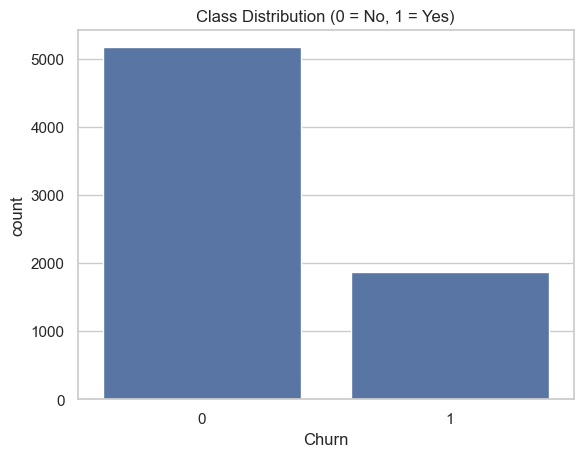


Numeric features (5):
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'ShortTenure_le1']

Categorical features (15):
 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
ShortTenure_le1,7043.0,0.088599,0.284184,0.00,0.00,0.000,0.0000,1.00


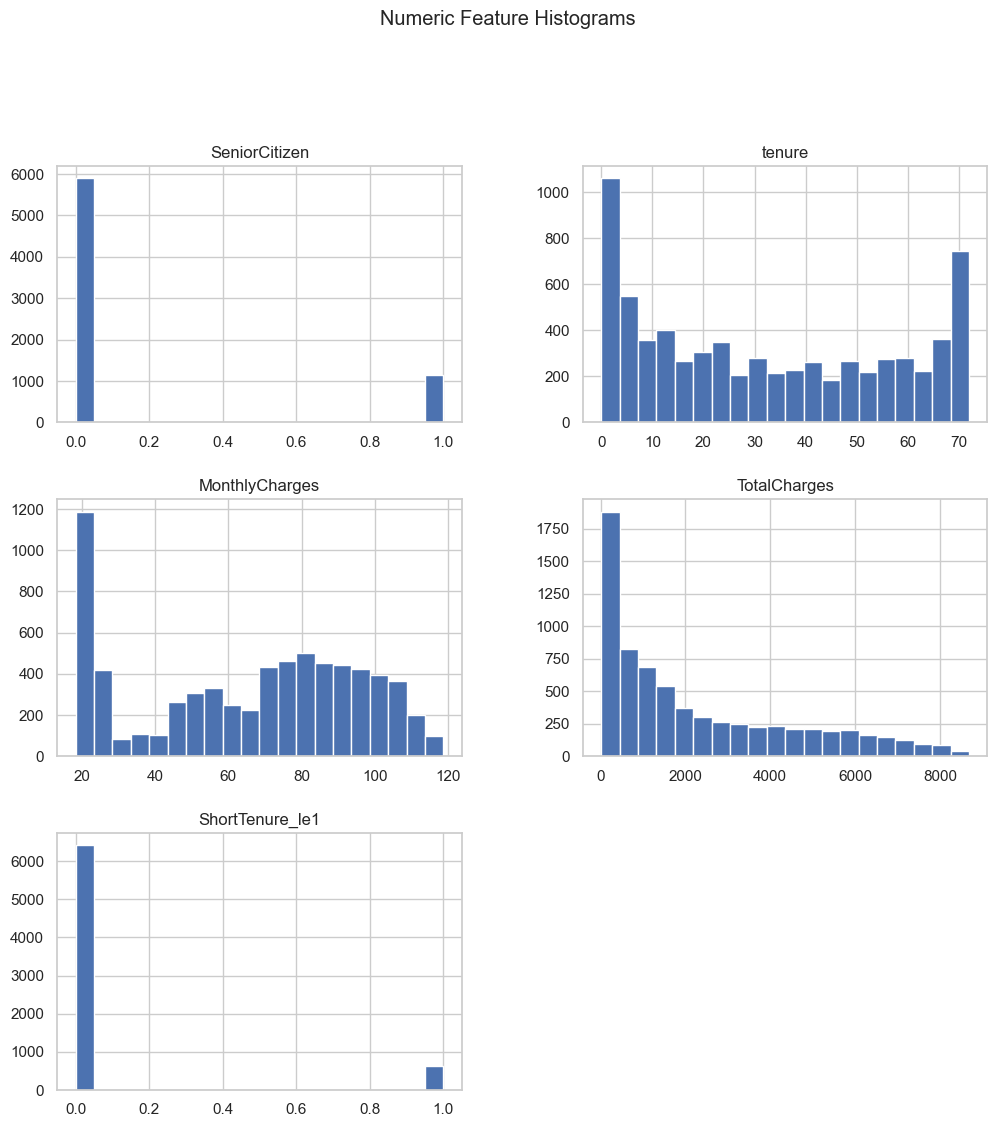

In [3]:
# Strip whitespace in column names
df.columns = df.columns.str.strip()

# Coerce known tricky numeric column (blanks -> NaN)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Keep TRUE target; map Yes/No -> 1/0
if df['Churn'].dtype == 'O':
    df['Churn'] = df['Churn'].astype(str).str.strip().str.lower().map({'yes':1, 'no':0})

# Drop rows with missing target
df = df.dropna(subset=['Churn']).copy()
df['Churn'] = df['Churn'].astype(int)

# Optional engineered flag (DO NOT overwrite target)
if 'tenure' in df.columns:
    df['ShortTenure_le1'] = (df['tenure'] <= 1).astype(int)

# Drop obvious IDs if present
for c in ['customerID','CustomerID','customer_id','id','ID']:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# =========================
# 3) EDA (Class distribution, summaries, quick histograms)
# =========================
print("\n=== Class Distribution ===")
print(df['Churn'].value_counts(dropna=False))
plt.figure()
sns.countplot(x='Churn', data=df)
plt.title('Class Distribution (0 = No, 1 = Yes)')
plt.show()

num_cols = df.select_dtypes(include='number').columns.tolist()
if 'Churn' in num_cols:
    num_cols.remove('Churn')
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumeric features ({len(num_cols)}):\n", num_cols)
print(f"\nCategorical features ({len(cat_cols)}):\n", cat_cols)

if num_cols:
    display(df[num_cols].describe().T)
    df[num_cols].hist(figsize=(12, 12), bins=20)
    plt.suptitle("Numeric Feature Histograms", y=1.01)
    plt.show()


=== Value Counts for Columns of Interest ===

Value Counts — gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64


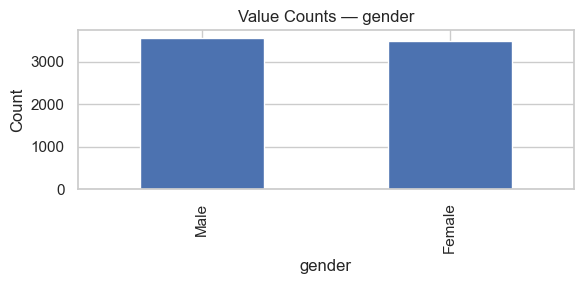


Value Counts — SeniorCitizen:
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


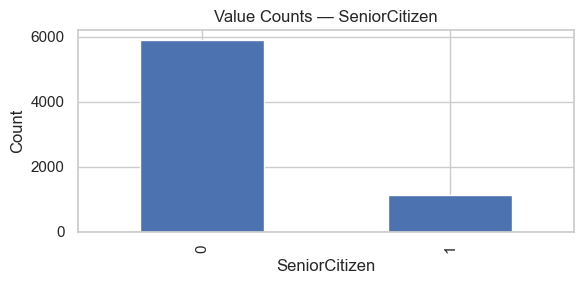


Value Counts — Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64


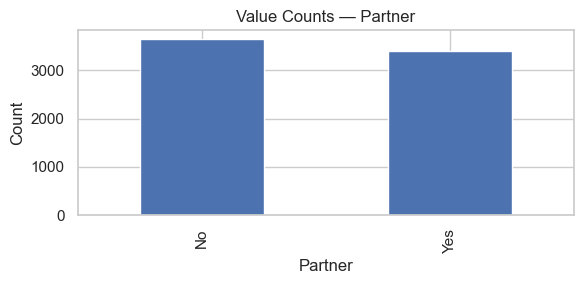


Value Counts — Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


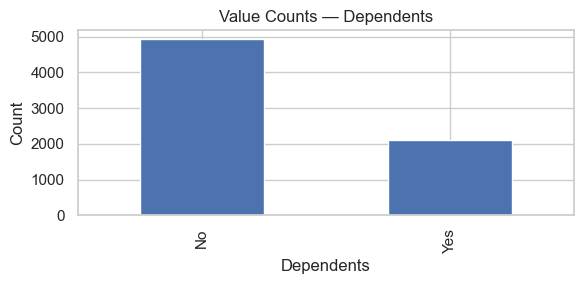


Value Counts — PhoneService:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64


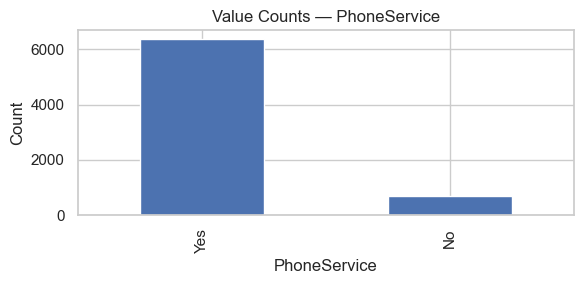


Value Counts — MultipleLines:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


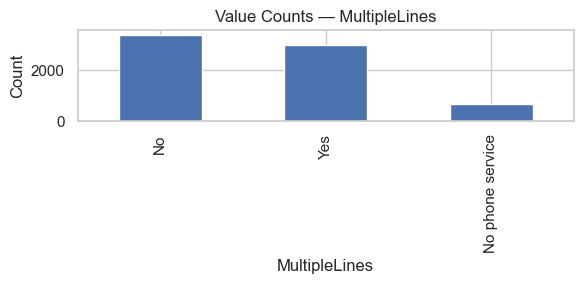


Value Counts — InternetService:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


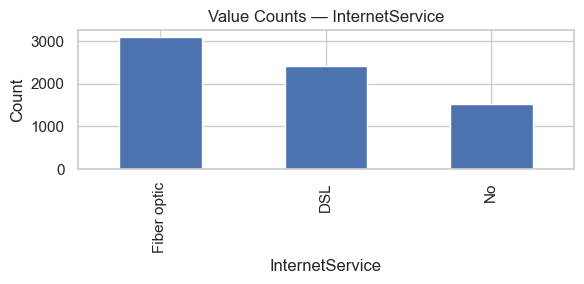


Value Counts — OnlineSecurity:
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


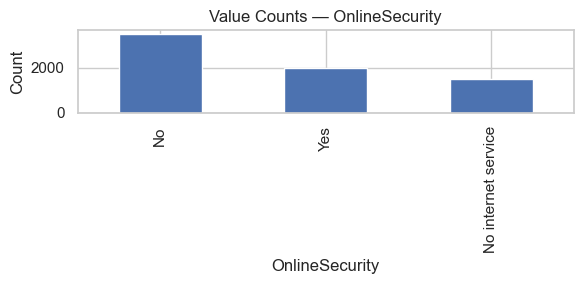


Value Counts — OnlineBackup:
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


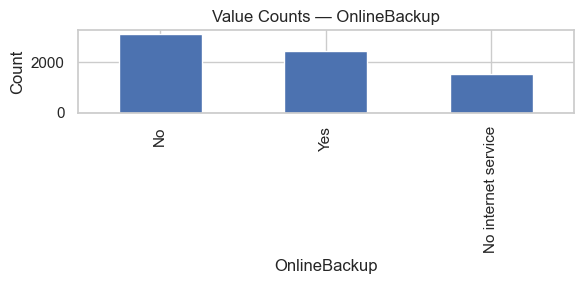


Value Counts — DeviceProtection:
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


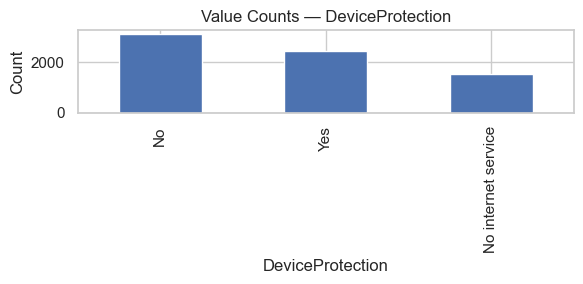


Value Counts — TechSupport:
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


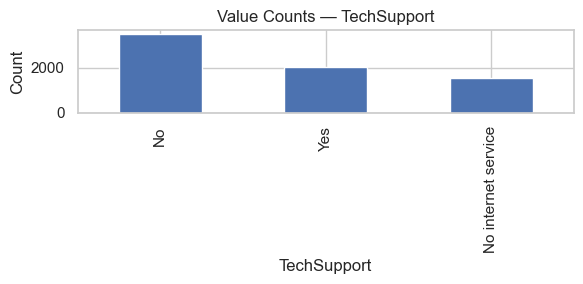


Value Counts — StreamingTV:
StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64


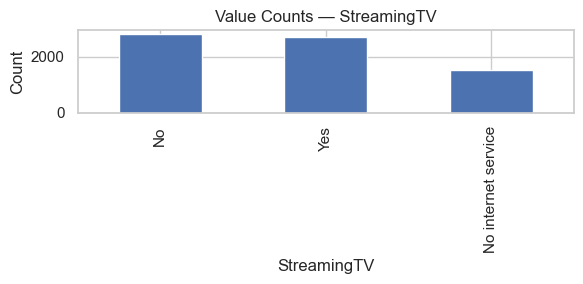


Value Counts — StreamingMovies:
StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


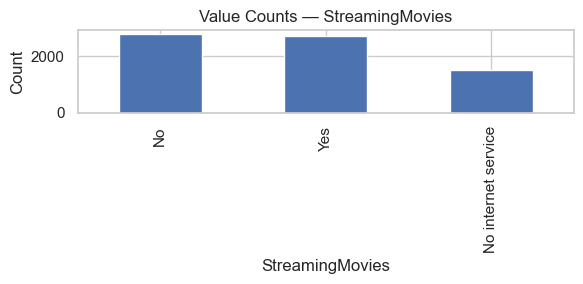


Value Counts — Contract:
Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


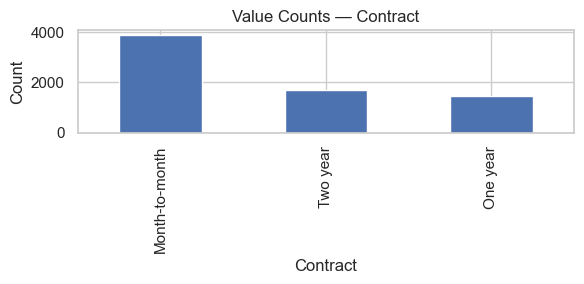


Value Counts — PaperlessBilling:
PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


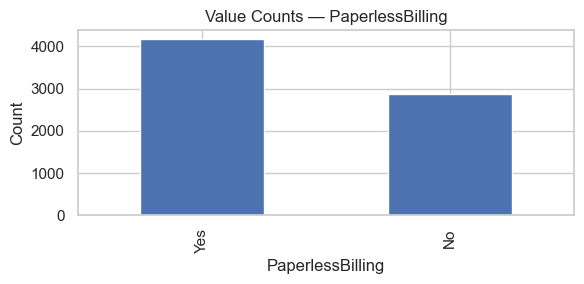


Value Counts — PaymentMethod:
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


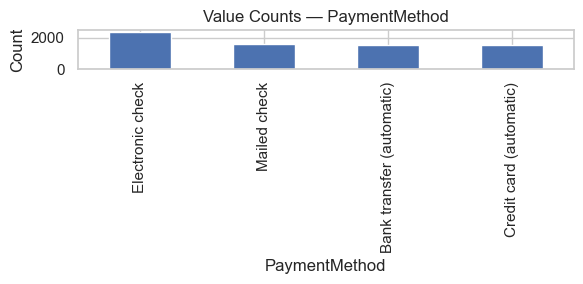

<Figure size 600x400 with 0 Axes>

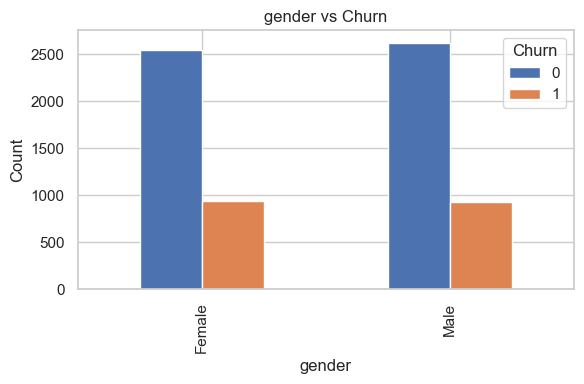

<Figure size 600x400 with 0 Axes>

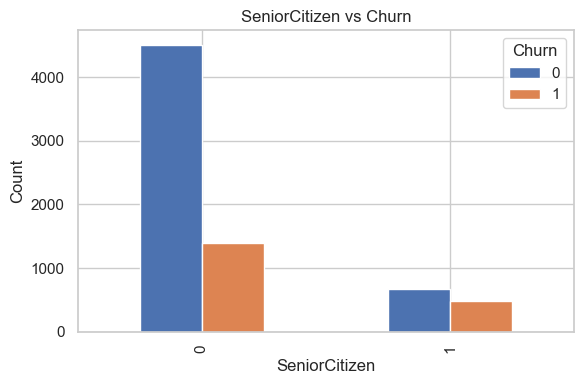

<Figure size 600x400 with 0 Axes>

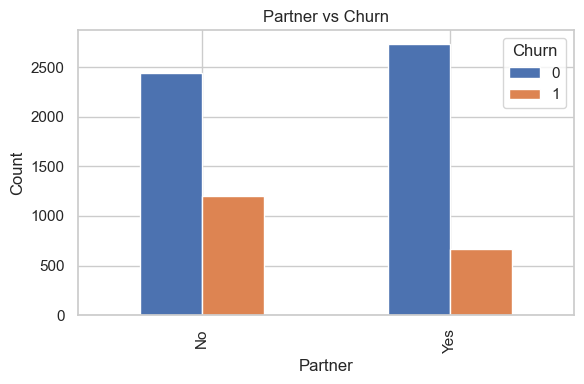

<Figure size 600x400 with 0 Axes>

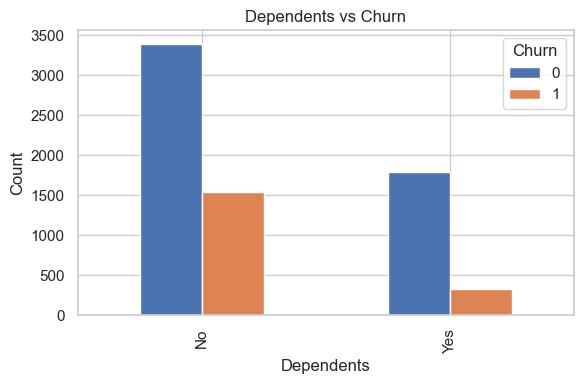

<Figure size 600x400 with 0 Axes>

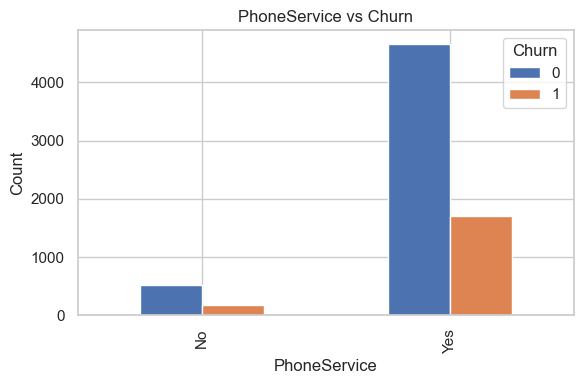

<Figure size 600x400 with 0 Axes>

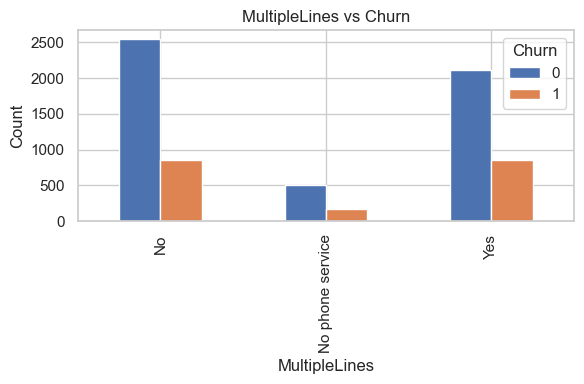

<Figure size 600x400 with 0 Axes>

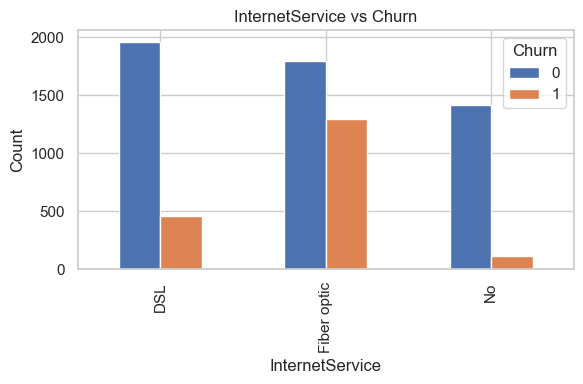

<Figure size 600x400 with 0 Axes>

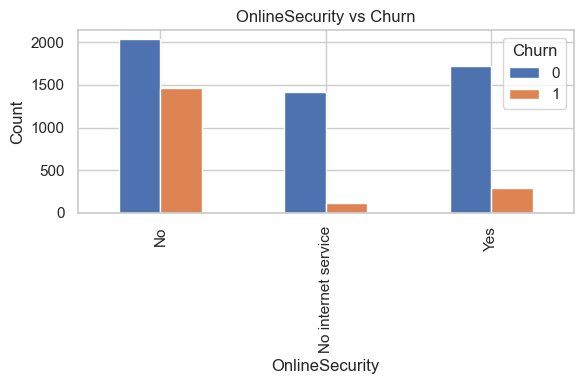

<Figure size 600x400 with 0 Axes>

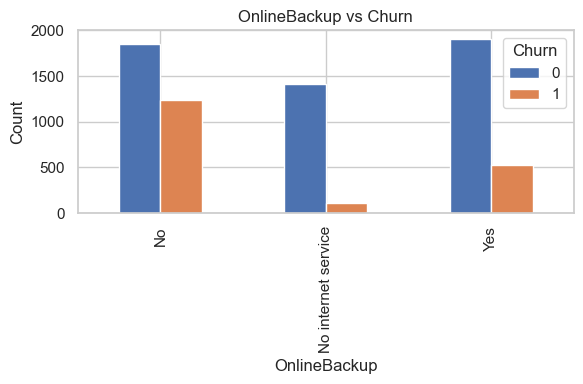

<Figure size 600x400 with 0 Axes>

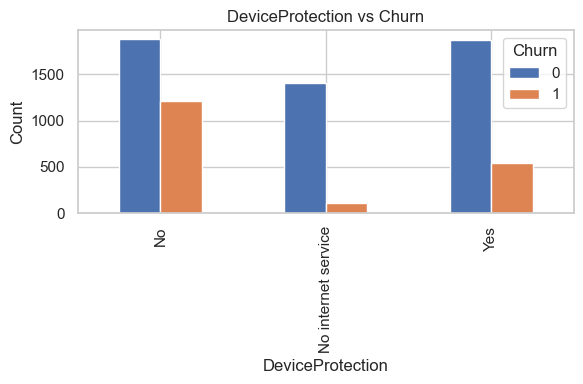

<Figure size 600x400 with 0 Axes>

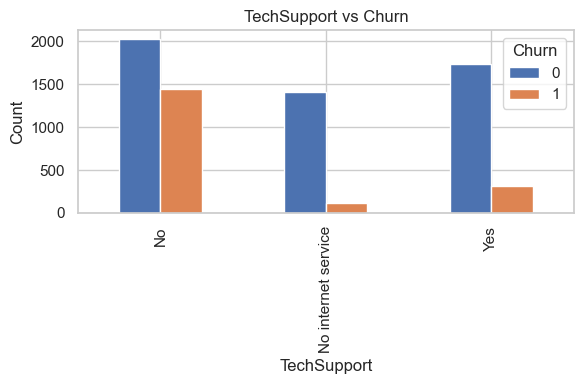

<Figure size 600x400 with 0 Axes>

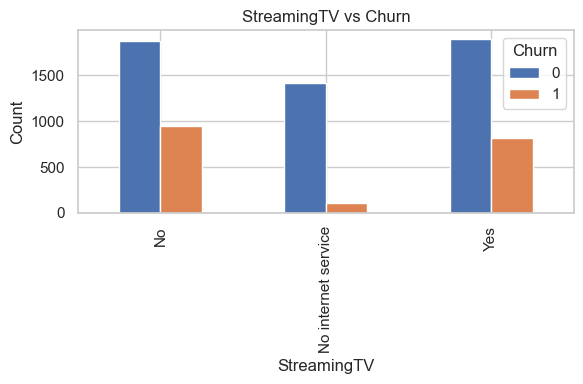

<Figure size 600x400 with 0 Axes>

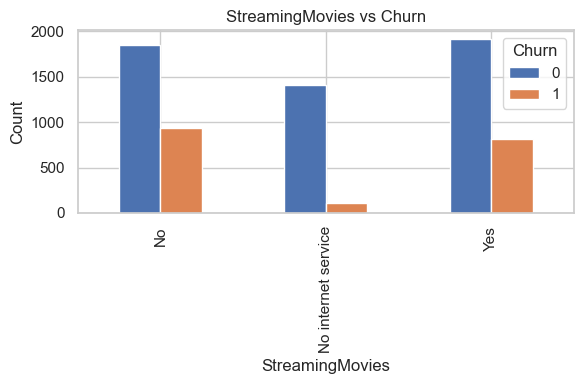

<Figure size 600x400 with 0 Axes>

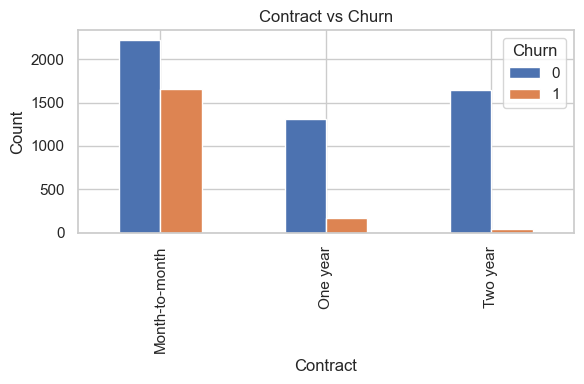

<Figure size 600x400 with 0 Axes>

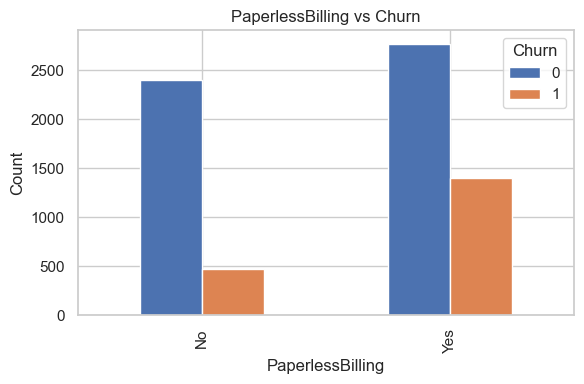

<Figure size 600x400 with 0 Axes>

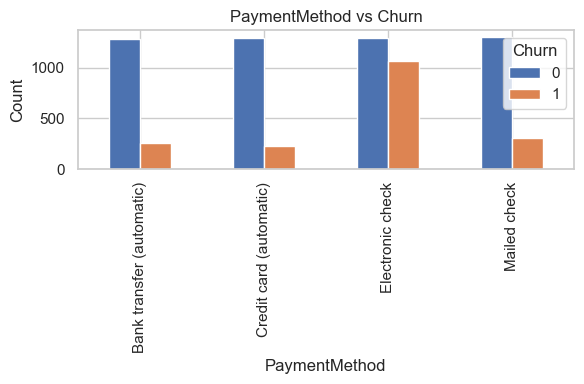

In [4]:
# =========================
# 4) Contingency tables & bar plots for selected categorical columns
# =========================
columns_of_interest = [
    'gender','SeniorCitizen','Partner','Dependents','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod'
]
columns_of_interest = [c for c in columns_of_interest if c in df.columns]

print("\n=== Value Counts for Columns of Interest ===")
for col in columns_of_interest:
    print(f"\nValue Counts — {col}:")
    print(df[col].value_counts(dropna=False))

    plt.figure(figsize=(6, 3))
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Value Counts — {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

for col in columns_of_interest:
    plt.figure(figsize=(6, 4))
    pd.crosstab(df[col], df['Churn']).plot(kind='bar', figsize=(6,4))
    plt.title(f"{col} vs Churn")
    plt.ylabel("Count"); plt.xlabel(col)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()


In [5]:
# =========================
# 5) FEATURE MATRIX / ENCODING
# =========================
X = df.drop(columns=['Churn'])
y = df['Churn']

cat_cols = X.select_dtypes(include=['object','category']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Fill NaNs from coercions (e.g., TotalCharges)
X = X.fillna(X.median(numeric_only=True)).fillna(0)

print("\nFinal feature matrix shape:", X.shape)


Final feature matrix shape: (7043, 31)


In [6]:
# =========================
# 6) TRAIN / TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [7]:
# =========================
# 7) METRICS HELPERS
# =========================
def evaluate_test(y_true, y_pred, y_prob=None, label="Model"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    print(f"\n=== {label} (TEST) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if not np.isnan(auc):
        print(f"ROC AUC  : {auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1":f1, "ROC_AUC":auc}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
    }

def cv_summary(name, pipe_or_model, X_all, y_all):
    res = cross_validate(pipe_or_model, X_all, y_all, cv=cv, scoring=scoring,
                         n_jobs=-1, return_train_score=False)
    row = {
        "Model": name,
        "CV_Accuracy":  np.mean(res["test_accuracy"]),
        "CV_Precision": np.mean(res["test_precision"]),
        "CV_Recall":    np.mean(res["test_recall"]),
        "CV_F1":        np.mean(res["test_f1"]),
        "CV_ROC_AUC":   np.mean(res["test_roc_auc"]),
    }
    return row


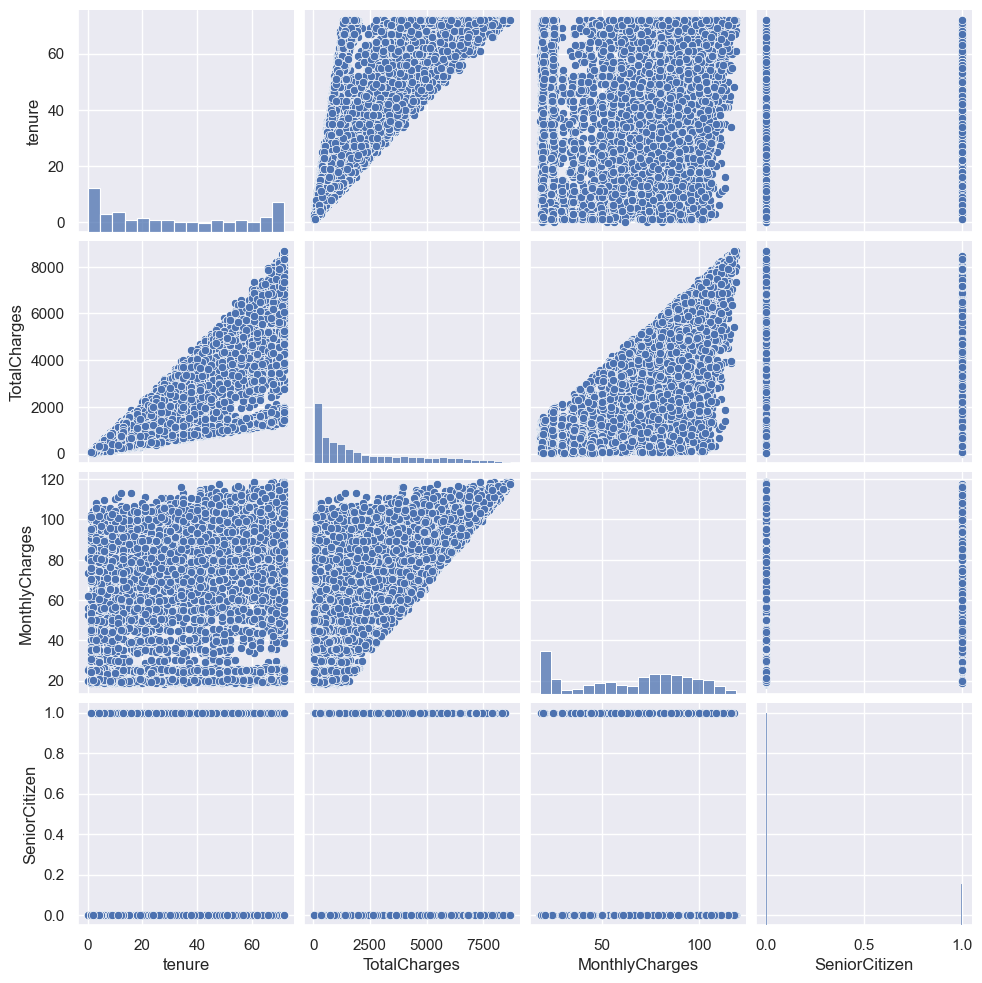

In [21]:
#Scatterplots comparing numeric features
sns.pairplot(df[['tenure','TotalCharges','MonthlyCharges','SeniorCitizen']])
plt.show()


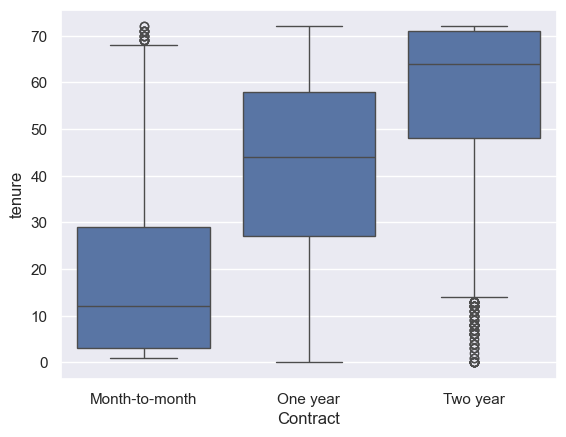

In [26]:
#Comparing the categorical value contract type and numerical tenure
sns.boxplot(data=df, x='Contract', y='tenure')
plt.show()

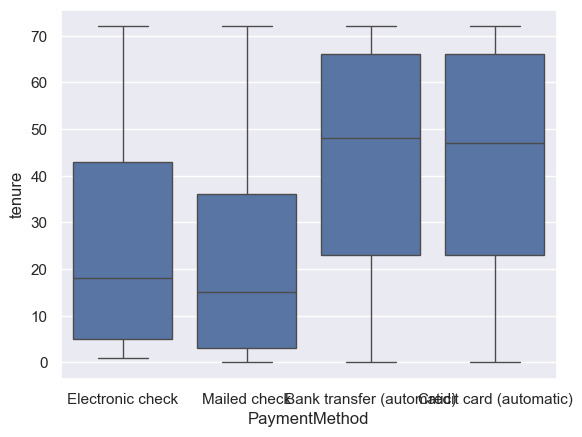

In [27]:
#Comparing the payment method to tenure
sns.boxplot(data=df, x='PaymentMethod', y='tenure')
plt.show()

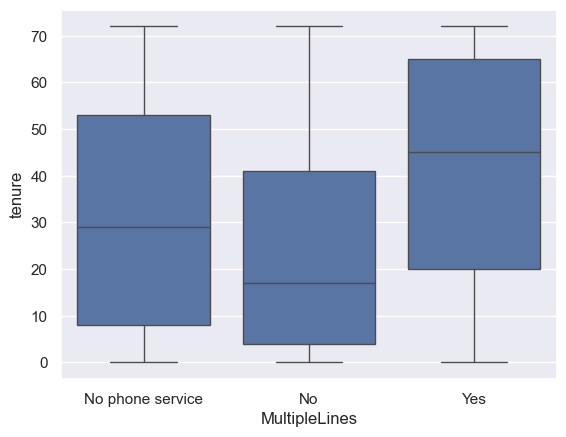

In [30]:
#Comparing the payment method to tenure
sns.boxplot(data=df, x='MultipleLines', y='tenure')
plt.show()

In [9]:
# =========================
# 8) BASELINES: Logistic (cost-sensitive) + RandomForest (cost-sensitive)
# =========================
logit = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced')
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
logit_prob = logit.predict_proba(X_test)[:, 1]
logit_test = evaluate_test(y_test, logit_pred, logit_prob, label="Logistic Regression (class_weight)")
logit_cv = cv_summary("Logistic (class_weight)", logit, X, y)

rf_weighted = RandomForestClassifier(
    n_estimators=400, class_weight="balanced_subsample",
    random_state=42, n_jobs=-1
)
rf_weighted.fit(X_train, y_train)
rfw_pred = rf_weighted.predict(X_test)
rfw_prob = rf_weighted.predict_proba(X_test)[:, 1]
rf_weighted_test = evaluate_test(y_test, rfw_pred, rfw_prob, label="RandomForest (class_weight)")
rf_weighted_cv = cv_summary("RandomForest (class_weight)", rf_weighted, X, y)



=== Logistic Regression (class_weight) (TEST) ===
Accuracy : 0.7395
Precision: 0.5059
Recall   : 0.8048
F1-score : 0.6213
ROC AUC  : 0.8478
Confusion Matrix:
 [[741 294]
 [ 73 301]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


=== RandomForest (class_weight) (TEST) ===
Accuracy : 0.7921
Precision: 0.6392
Recall   : 0.4973
F1-score : 0.5594
ROC AUC  : 0.8261
Confusion Matrix:
 [[930 105]
 [188 186]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71   

In [10]:
# =========================
# 9) SMOTE VARIANTS: RF + SVM + KNN (with CV and Test)
#    (SMOTE applied only to training folds via imblearn Pipeline)
# =========================
# RF + SMOTE
rf_smote = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])
rf_smote_cv = cv_summary("RandomForest + SMOTE", rf_smote, X, y)
rf_smote.fit(X_train, y_train)
rf_smote_pred = rf_smote.predict(X_test)
rf_smote_prob = rf_smote.predict_proba(X_test)[:, 1]
rf_smote_test = evaluate_test(y_test, rf_smote_pred, rf_smote_prob, label="RandomForest + SMOTE")

# SVM (RBF) + SMOTE (+ scaling)
svm_smote = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("scale", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True))
])
svm_smote_cv = cv_summary("SVM (RBF) + SMOTE", svm_smote, X, y)
svm_smote.fit(X_train, y_train)
svm_smote_pred = svm_smote.predict(X_test)
svm_smote_prob = svm_smote.predict_proba(X_test)[:, 1]
svm_smote_test = evaluate_test(y_test, svm_smote_pred, svm_smote_prob, label="SVM (RBF) + SMOTE")

# KNN + SMOTE (+ scaling)
knn_smote = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("scale", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15))
])
knn_smote_cv = cv_summary("KNN (k=15) + SMOTE", knn_smote, X, y)
knn_smote.fit(X_train, y_train)
knn_smote_pred = knn_smote.predict(X_test)
knn_smote_prob = knn_smote.predict_proba(X_test)[:, 1]
knn_smote_test = evaluate_test(y_test, knn_smote_pred, knn_smote_prob, label="KNN (k=15) + SMOTE")



=== RandomForest + SMOTE (TEST) ===
Accuracy : 0.7779
Precision: 0.5780
Recall   : 0.6043
F1-score : 0.5908
ROC AUC  : 0.8212
Confusion Matrix:
 [[870 165]
 [148 226]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409


=== SVM (RBF) + SMOTE (TEST) ===
Accuracy : 0.7700
Precision: 0.5581
Recall   : 0.6417
F1-score : 0.5970
ROC AUC  : 0.8045
Confusion Matrix:
 [[845 190]
 [134 240]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.64      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg    

In [11]:
# =========================
# 10) COLLECT & DISPLAY COMPARISON TABLES
# =========================
cv_rows = [
    logit_cv, rf_weighted_cv,
    rf_smote_cv, svm_smote_cv, knn_smote_cv
]
cv_df = pd.DataFrame(cv_rows).sort_values("CV_F1", ascending=False)

def pack_test_row(name, d):
    return {
        "Model": name,
        "TEST_Accuracy": d["Accuracy"],
        "TEST_Precision": d["Precision"],
        "TEST_Recall": d["Recall"],
        "TEST_F1": d["F1"],
        "TEST_ROC_AUC": d["ROC_AUC"],
    }

test_rows = [
    pack_test_row("Logistic (class_weight)", logit_test),
    pack_test_row("RandomForest (class_weight)", rf_weighted_test),
    pack_test_row("RandomForest + SMOTE", rf_smote_test),
    pack_test_row("SVM (RBF) + SMOTE", svm_smote_test),
    pack_test_row("KNN (k=15) + SMOTE", knn_smote_test),
]
test_df = pd.DataFrame(test_rows).sort_values("TEST_F1", ascending=False)

print("\n\n==== 5-Fold Cross-Validation (means) ====")
display(cv_df.style.format({
    "CV_Accuracy":"{:.4f}", "CV_Precision":"{:.4f}",
    "CV_Recall":"{:.4f}", "CV_F1":"{:.4f}", "CV_ROC_AUC":"{:.4f}"
}))

print("\n==== Held-out TEST Set Metrics ====")
display(test_df.style.format({
    "TEST_Accuracy":"{:.4f}", "TEST_Precision":"{:.4f}",
    "TEST_Recall":"{:.4f}", "TEST_F1":"{:.4f}", "TEST_ROC_AUC":"{:.4f}"
}))




==== 5-Fold Cross-Validation (means) ====


,Model,CV_Accuracy,CV_Precision,CV_Recall,CV_F1,CV_ROC_AUC
0,Logistic (class_weight),0.7487,0.5169,0.8111,0.6313,0.8483
3,SVM (RBF) + SMOTE,0.7843,0.5848,0.6452,0.6135,0.8132
4,KNN (k=15) + SMOTE,0.7382,0.5046,0.7143,0.5914,0.8100
2,RandomForest + SMOTE,0.7791,0.5841,0.5810,0.5823,0.8213
1,RandomForest (class_weight),0.7894,0.6382,0.4762,0.5452,0.8266



==== Held-out TEST Set Metrics ====


,Model,TEST_Accuracy,TEST_Precision,TEST_Recall,TEST_F1,TEST_ROC_AUC
0,Logistic (class_weight),0.7395,0.5059,0.8048,0.6213,0.8478
3,SVM (RBF) + SMOTE,0.7700,0.5581,0.6417,0.5970,0.8045
2,RandomForest + SMOTE,0.7779,0.5780,0.6043,0.5908,0.8212
4,KNN (k=15) + SMOTE,0.7282,0.4916,0.7059,0.5796,0.7953
1,RandomForest (class_weight),0.7921,0.6392,0.4973,0.5594,0.8261


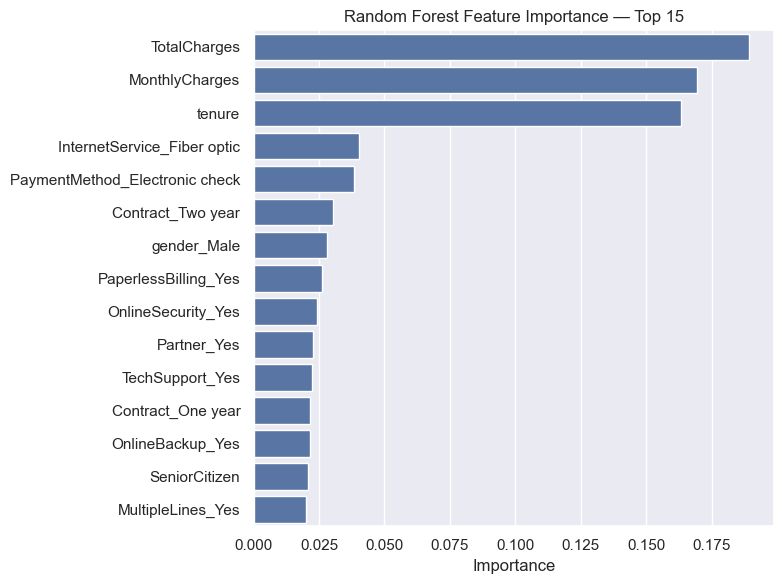

TotalCharges                             0.189328
MonthlyCharges                           0.169421
tenure                                   0.163125
InternetService_Fiber optic              0.040212
PaymentMethod_Electronic check           0.038393
Contract_Two year                        0.030361
gender_Male                              0.028217
PaperlessBilling_Yes                     0.025948
OnlineSecurity_Yes                       0.024227
Partner_Yes                              0.022864
TechSupport_Yes                          0.022419
Contract_One year                        0.021521
OnlineBackup_Yes                         0.021419
SeniorCitizen                            0.020949
MultipleLines_Yes                        0.019944
Dependents_Yes                           0.019852
DeviceProtection_Yes                     0.018912
ShortTenure_le1                          0.018650
StreamingMovies_Yes                      0.017368
StreamingTV_Yes                          0.016862


In [12]:
# =========================
# 11) OPTIONAL: FEATURE IMPORTANCE (RF variants)
# =========================
# Train a plain RF on full data for feature importances (fast overview)
rf_full = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf_full.fit(X, y)
importances = pd.Series(rf_full.feature_importances_, index=X.columns).sort_values(ascending=False)

top_k = 15
plt.figure(figsize=(8, 6))
sns.barplot(x=importances.head(top_k), y=importances.head(top_k).index)
plt.title(f"Random Forest Feature Importance — Top {top_k}")
plt.xlabel("Importance"); plt.ylabel("")
plt.tight_layout()
plt.show()
display(importances.head(30))

In [13]:
# =========================
# 12) NOTES / REPORT HINTS
# =========================
print("""
REPORT NOTES / CHECKLIST:
- Problem: binary classification with class imbalance (Telco churn).
- Cleaning: handled TotalCharges (coerce numeric), removed NA Churn, dropped ID cols, added ShortTenure_le1 feature.
- EDA: class distribution, value counts, crosstabs, histograms; note any anomalies/skew.
- Modeling:
  * Cost-sensitive baselines: Logistic (class_weight), RF (class_weight).
  * SMOTE pipelines: RF + SMOTE, SVM (RBF) + SMOTE + scaling, KNN + SMOTE + scaling.
- Validation:
  * 5-fold Stratified CV using F1/Recall/ROC-AUC; plus held-out TEST metrics.
  * Focus on minority (churn=1) metrics, especially Recall and F1.
- Findings:
  * Compare SMOTE vs class_weight; which improves Recall/F1 most?
  * Note trade-offs (Precision drops when Recall rises).
- Recommendations:
  * Try hyperparameter tuning (GridSearchCV) for SVM (C, gamma), RF (depth, features), KNN (k).
  * Consider PR curves and threshold tuning to optimize Recall or F1 for churn class.
  * Evaluate cost of false negatives (missed churners) vs false positives (unnecessary retention offers).
""")



REPORT NOTES / CHECKLIST:
- Problem: binary classification with class imbalance (Telco churn).
- Cleaning: handled TotalCharges (coerce numeric), removed NA Churn, dropped ID cols, added ShortTenure_le1 feature.
- EDA: class distribution, value counts, crosstabs, histograms; note any anomalies/skew.
- Modeling:
  * Cost-sensitive baselines: Logistic (class_weight), RF (class_weight).
  * SMOTE pipelines: RF + SMOTE, SVM (RBF) + SMOTE + scaling, KNN + SMOTE + scaling.
- Validation:
  * 5-fold Stratified CV using F1/Recall/ROC-AUC; plus held-out TEST metrics.
  * Focus on minority (churn=1) metrics, especially Recall and F1.
- Findings:
  * Compare SMOTE vs class_weight; which improves Recall/F1 most?
  * Note trade-offs (Precision drops when Recall rises).
- Recommendations:
  * Try hyperparameter tuning (GridSearchCV) for SVM (C, gamma), RF (depth, features), KNN (k).
  * Consider PR curves and threshold tuning to optimize Recall or F1 for churn class.
  * Evaluate cost of false negat